In [34]:
import math
import random

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from kan import KAN as PyKAN
from matplotlib import pyplot as plt
from torch import nn, optim
from tqdm import tqdm

from efficient_kan.kan import KAN as EffKAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reducing the lookup table size
The goal of this experiment is to use KAN's regression capability to approximate the popular multivariate Newton's Law of Gravity to a sum of univariate functions in order to reduce the size of the lookup table.

*Since we could not train a reasonably good PyKAN, we used an EfficientKAN instead.* After obtaining a reasonable training result, we show how the lookup table grows linearly with the number of samples of the input variables. Considering that the classic lookup table grows $\mathcal{O}(N^d)$, this is a huge size reduction.

## Generate the dataset

In [9]:
G = 1  #6.67430e-11


def generate_dataset(num_samples=1000):
    m1, m2 = np.random.uniform(0.1, 1, num_samples), np.random.uniform(0.1, 1, num_samples)
    d = np.random.uniform(0.1, 1, num_samples)
    return np.column_stack((m1, m2, d)), (m1 * m2) / (d ** 2)


train_set = generate_dataset(num_samples=10000)
test_set = generate_dataset(num_samples=5000)
dataset = {
    'train_input': torch.tensor(train_set[0], dtype=torch.float32),
    'train_label': torch.tensor(train_set[1], dtype=torch.float32),
    'test_input': torch.tensor(test_set[0], dtype=torch.float32),
    'test_label': torch.tensor(test_set[1], dtype=torch.float32),
}

## Train the KAN

In [32]:
model = PyKAN(width=[3, 3, 3, 3, 1, 1], grid=3, k=3, grid_range=[0.5, 1])
model.fit(dataset, opt="LBFGS", steps=40, lamb=0.01, lamb_entropy=100)
pass

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.00e-01 | test_loss: 9.91e+00 | reg: 1.83e+02 | : 100%|█| 40/40 [00:29<00:00,  1.37it

saving model version 0.1


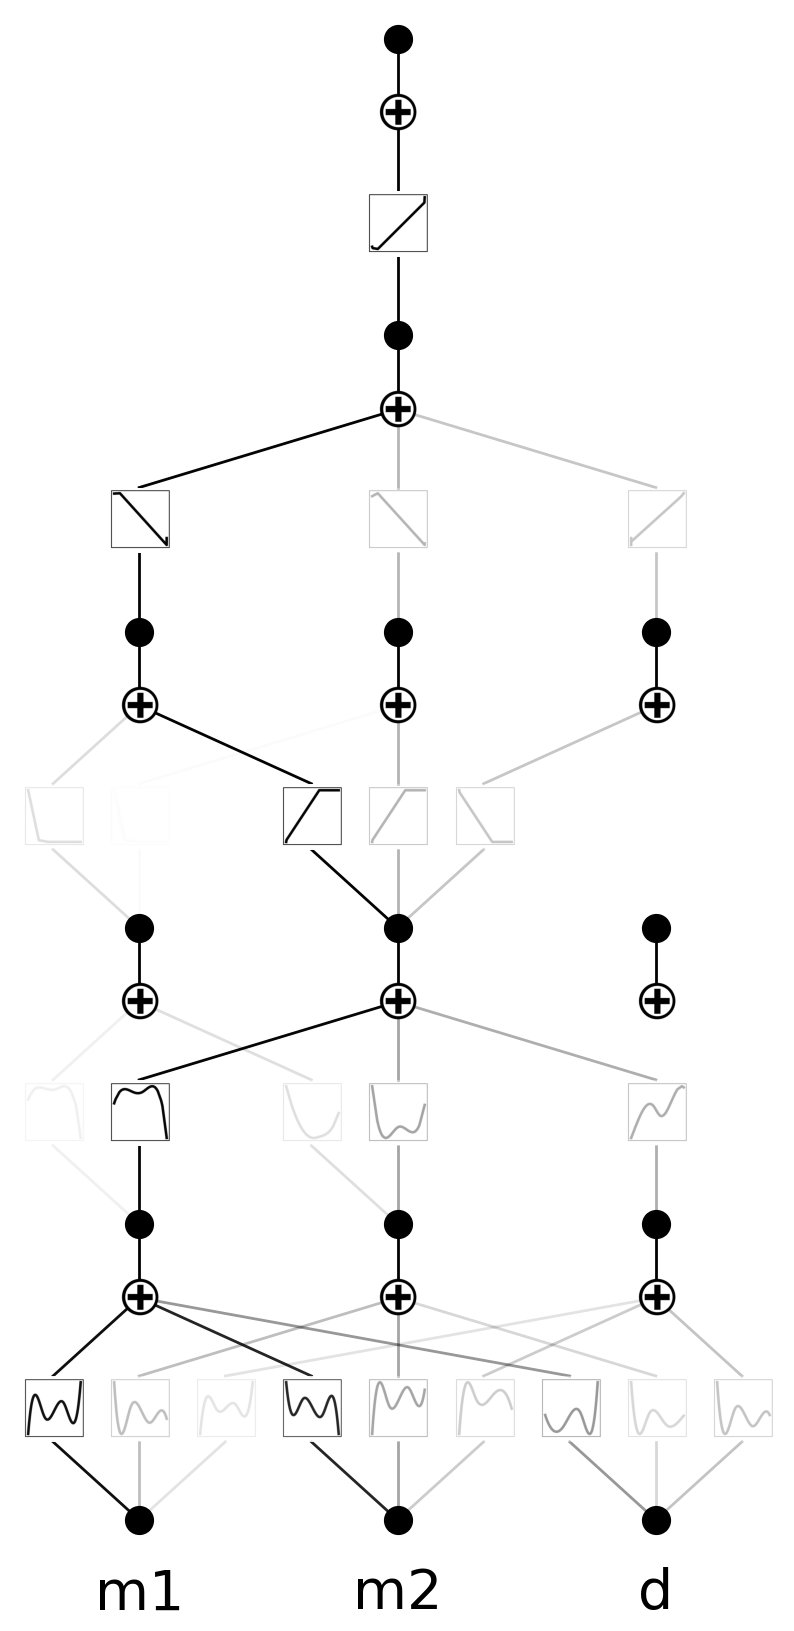

In [33]:
model.plot(in_vars=['m1', 'm2', 'd'], scale=1)

## EfficientKAN

In [21]:
class Efficient_KAN(nn.Module):
    def __init__(self, grid_size=200, shape=None):
        super(Efficient_KAN, self).__init__()
        if shape is None:
            shape = [1, 1]
        self.layers = shape
        self.model = EffKAN(self.layers,
                            grid_size=grid_size,
                            scale_base=0,
                            # sp_trainable=False,
                            sb_trainable=False,
                            ).to(device)
        self.double()

    def forward(self, x):
        return self.model(x)

In [5]:
def train(model, optimizer, inputs: torch.Tensor, labels, epochs=5, batch_size=100):
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    for epoch in range(epochs):
        model.train()
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size].to(device)
                y = labels[i * batch_size:(i + 1) * batch_size].to(device)
                optimizer.zero_grad()
                output = model(x)
                output = output.squeeze()
                loss = criterion(output, y.double())
                loss.backward()
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
                scheduler.step()

In [6]:
def test(model, inputs, labels, batch_size=100):
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size].to(device)
                y = labels[i * batch_size:(i + 1) * batch_size].to(device)
                output = model(x).cpu()
                output = output.squeeze()
                losses.append(criterion(output, y.double()))
    return (sum(losses) / len(losses)).item()

In [22]:
model2 = Efficient_KAN(grid_size=5, shape=[3, 3, 3, 1])

In [27]:
train(model2, optim.Adam(model2.parameters(), lr=0.025), dataset["train_input"], dataset["train_label"], epochs=200,
      batch_size=10000)

100%|██████████| 1/1 [00:00<00:00, 26.21it/s, loss=0.0105, lr=0.0205]


In [18]:
test(model2, dataset["test_input"], dataset["test_label"])

100%|██████████| 50/50 [00:00<00:00, 623.39it/s]


0.014500555023972905

In [19]:
def plot_spline(model: EffKAN, x_range, scale=1, resolution=50):
    base_colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

    def random_color():
        return random.random(), random.random(), random.random()

    colors = [base_colors[x] if x < len(base_colors) else random_color()
              for x in range(max(map(lambda l: l.in_features, model.layers)))]
    for layer in reversed(model.layers):
        fig, axes = plt.subplots(1, layer.in_features * layer.out_features,
                                 figsize=(2 * scale * layer.in_features * layer.out_features, 2 * scale))
        for i in range(layer.in_features):
            for j in range(layer.out_features):
                x_vals = torch.linspace(x_range[0], x_range[1], resolution)
                # expanded_x_vals = torch.cat((x_vals, torch.zeros(resolution * (layer.in_features - 1))))
                # y_vals = F.linear(
                #     layer.b_splines(expanded_x_vals.view(-1, layer.in_features)),
                #     layer.scaled_spline_weight.view(layer.in_features * layer.out_features, -1),
                # ).view(-1).detach()[:resolution]
                # y_vals += (layer.base_activation(x_vals) * layer.base_weight[j, i])

                # B-Splines
                grid = layer.grid[j, :].unsqueeze(0)  # The knots
                x = x_vals.unsqueeze(-1).unsqueeze(-1)
                bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)  # Determine the interval for each point
                for k in range(1, layer.spline_order + 1):
                    bases = (
                                    (x - grid[:, : -(k + 1)])
                                    / (grid[:, k:-1] - grid[:, : -(k + 1)])
                                    * bases[:, :, :-1]
                            ) + (
                                    (grid[:, k + 1:] - x)
                                    / (grid[:, k + 1:] - grid[:, 1:(-k)])
                                    * bases[:, :, 1:]
                            )

                y_vals = F.linear(bases.squeeze(), layer.scaled_spline_weight[j, i]).detach()
                y_vals += (layer.base_activation(x_vals) * layer.base_weight[j, i])

                alpha = math.tanh(abs(3 * layer.spline_scaler.view(layer.out_features, -1)[j, i].item()))
                if type(axes) is np.ndarray:
                    axes[i * layer.out_features + j].plot(x_vals, y_vals.detach(), alpha=alpha, color=colors[i])
                    axes[i * layer.out_features + j].grid(True)
                else:
                    axes.plot(x_vals, y_vals.detach(), alpha=alpha, color=colors[i])
                    axes.grid(True)

    # plt.tight_layout()
    plt.show()

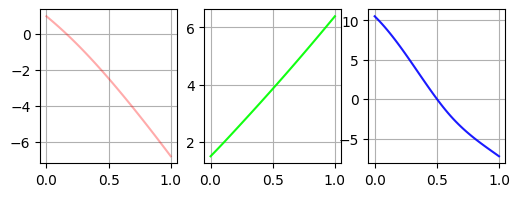

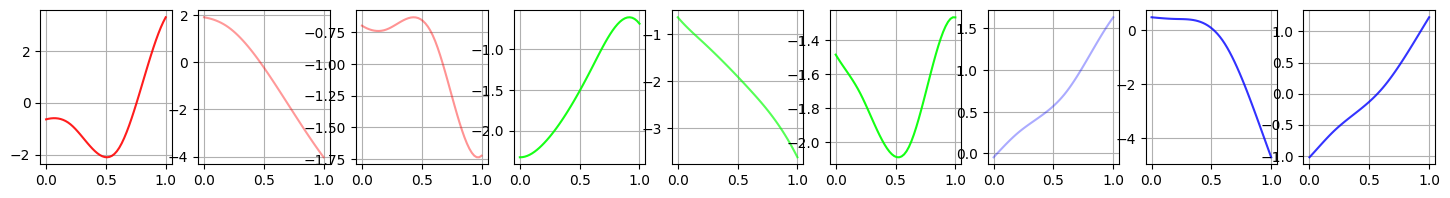

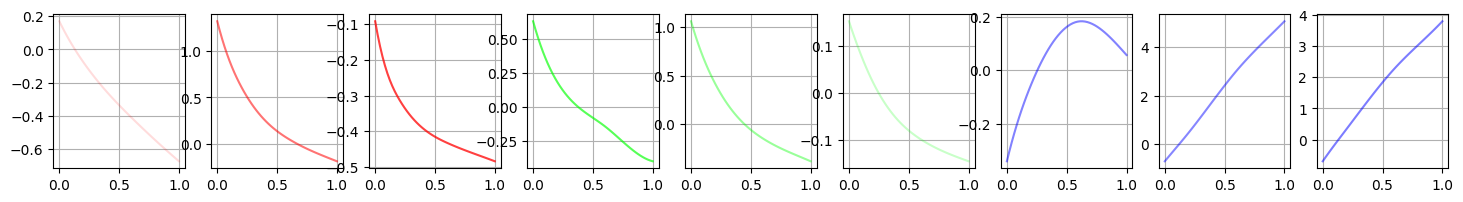

In [28]:
plot_spline(model2.model, [0, 1])

## Reducing the lookup table size

### Classic Lookup table
The number of stored rows is:

$$TotalRows(N) = \mathcal{O}(N^3)$$

where N is the number of samples for each input variable.

In [61]:
samples = 100  # The number of different values for each input variable
input_range = [0.1, 1]

In [55]:
m1, m2, d = torch.meshgrid(torch.linspace(input_range[0], input_range[1], steps=samples),
                           torch.linspace(input_range[0], input_range[1], steps=samples),
                           torch.linspace(input_range[0], input_range[1], steps=samples), indexing="ij")
values = model2(torch.stack([m1.flatten(), m2.flatten(), d.flatten()], dim=1)).detach()
lookup_table = torch.stack([m1.flatten(), m2.flatten(), d.flatten(), values.flatten()], dim=1)
df = pd.DataFrame(lookup_table.numpy(), columns=['m1', 'm2', 'd', 'F(m1, m2, d)'])

memory_bytes = df.memory_usage(deep=True).sum()
print(f"Memory usage: {memory_bytes / 1024 ** 2:.2f} MB")

Memory usage: 30.52 MB


### KAN Lookup tables
The number of stored rows is:

$$TotalRows(N)=c\cdot N = \mathcal{O}(N)$$

where N is the number of samples for each input variable.

In [62]:
lookup_tables = []
indices = []
for l, layer in enumerate(model2.model.layers):
    for i in range(layer.in_features):
        for j in range(layer.out_features):
            x_vals = torch.linspace(input_range[0], input_range[1], samples)
            grid = layer.grid[j, :].unsqueeze(0)  # The knots
            x = x_vals.unsqueeze(-1).unsqueeze(-1)
            bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)  # Determine the interval for each point
            for k in range(1, layer.spline_order + 1):
                bases = (
                                (x - grid[:, : -(k + 1)])
                                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                                * bases[:, :, :-1]
                        ) + (
                                (grid[:, k + 1:] - x)
                                / (grid[:, k + 1:] - grid[:, 1:(-k)])
                                * bases[:, :, 1:]
                        )

            y_vals = F.linear(bases.squeeze(), layer.scaled_spline_weight[j, i])
            y_vals += (layer.base_activation(x_vals) * layer.base_weight[j, i])

            lookup_tables.append(torch.stack([x_vals.flatten(), y_vals.detach().flatten()], dim=1))
            indices.append((l, i, j))
dfs = [pd.DataFrame(table.numpy(), columns=['in', f'out ({indices[i]})']) for i, table in enumerate(lookup_tables)]

memory_bytes = sum(df.memory_usage(deep=True).sum() for df in dfs)
print(f"Memory usage: {memory_bytes / 1024 ** 2:.2f} MB")
print(f'Lookup tables: {len(dfs)}. Total rows: {len(dfs)*len(dfs[0])}')

Memory usage: 0.03 MB
Lookup tables: 21. Total rows: 2100
